<a href="https://colab.research.google.com/github/NidaNabi/implementation-of-Joint-t-SNE/blob/main/Joint_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Joint t-Stochastic Neighbour Embedding (Joint t-SNE)**


### Joint t-Stochastic Neighbour Embedding (Joint t-SNE) is a technique to generate comparable projections of multiple high-dimensional datasets. When a series of high-dimensional datasets, such as datasets changing over time, is projected independently using t-SNE, misaligned layouts are obtained. Even items with identical features across datasets are projected to different locations, making the technique unsuitable for comparison tasks. To tackle this problem, we use joint t-SNE that in turn uses edge similarity, which captures the similarities between two adjacent time frames based on the Graphlet Frequency Distribution (GFD). It then integrates a novel loss term into the t-SNE loss function to preserve the vectors between projected points across the projections, allowing these points to serve as visual landmarks for direct comparisons between projections.

### Installing necessary Libraries

In [1]:
!pip install six

### Importing necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib as plt2

from __future__ import division
from sklearn import manifold
import warnings
from time import time
from scipy import linalg
import scipy.sparse as sp
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import _utils
from sklearn.manifold import _barnes_hut_tsne
from six import string_types
from sklearn.utils import deprecated
MACHINE_EPSILON = np.finfo(np.double).eps

import pylab
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
scaler = StandardScaler()

from abc import ABC, abstractmethod
from time import perf_counter
from functools import wraps
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import trustworthiness

import warnings
warnings.filterwarnings('ignore')

In [3]:
def recall(Fvec, label):
    """This function is used to find the nearest same-class points similarity for each instance
    and neareat different-class similarity points for each instance.
    Parameters
    ----------
    Fvec : Tensor, shape (n_samples, n_features)
    Embedding representation.
    label : List, length (n_feafures)
    Label for each instance.
    Returns
    -------
    disList : List, shape (n_features,2)
    Two similarity(nearest same-class and nearest diff-class) for each instance.
    """
    N = len(label)
    print(N)
    disList = []

    D = Fvec.mm(torch.t(Fvec))

    D[torch.eye(N).byte()] = -1

    sort_D, indices = torch.sort(D,1,descending=True)
    print(indices[0])
    for i in range(0,N):
        dis = []
        distance = sort_D[i]
        index = indices[i]

        for j in range(0,N):
            if label[index[j].item()]==label[i]:
                dis.append(distance[j].item())
                break;

        for k in range(0,N):
            if label[index[k].item()]!=label[i]:
                dis.append(distance[k].item())
                break;

        disList.append(dis)
    return disList

def draw_sca(disList,name='',savepath='./'):
    """ This function is used to generate similarity scatter plot and save it.
    Parameters
    ----------
    disList : List, shape (n_features,2)
    Two similarity(nearest same-class and nearest diff-class) for each instance.

    name : String
    Title of scatter plot

    savepath : String
    Path to save this plot

    """

    disList = np.asarray(disList)
    print(disList.shape)
    A=disList[:,0]
    B=disList[:,1]
    diff=B>A
    same=A>B
    plt.figure(figsize=(6.4,6.4))
    plt.title(name)
    plt.xlim(0.3,1.0)
    plt.ylim(0.3,1.0)
    plt.xlabel('Similarity (Same class)',fontsize=22)
    plt.ylabel('Similarity (Different class)',fontsize=22)
    samex = A[same]
    samey = B[same]
    difx = A[diff]
    dify = B[diff]
    plt.scatter(samex,samey,c='c',s=0.1)
    plt.scatter(difx,dify,color=[1.0, 0.5, 0.25],s=0.1)
    if not os.path.isdir(savepath):
        os.makedirs(savepath)
    plt.savefig(savepath+'scatter_plot.jpg')

def gene_sca(vecPath,labelPath,name='',savepath='./'):
    """ This function is used to find generate similarity list, generate similarity scatter plot and save it.
    Parameters
    ----------
    vecPath : String
    Path saving embedding vector

    labelPath : String
    Path saving label

    name : String
    Title of scatter plot

    savepath : String
    Path to save this plot
    """
    #Fvec = torch.load(vecPath)
    Fvec = np.load(vecPath)
    #label = torch.load(labelPath)
    label = np.load(labelPath)
    Fvec = torch.Tensor(Fvec)
    disList = recall(Fvec,label)
    draw_sca(disList,name,savepath)

## Implementation of Joint TSNE

In [17]:
def _joint_probabilities(distances, desired_perplexity, verbose):
    distances = distances.astype(np.float32, copy=False)
    conditional_P = _utils._binary_search_perplexity(
        distances, None, desired_perplexity, verbose)
    P = conditional_P + conditional_P.T
    sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
    P = np.maximum(squareform(P) / sum_P, MACHINE_EPSILON)
    return P

def _joint_probabilities_nn(distances, neighbors,desired_perplexity, verbose):
    t0 = time()
    n_samples, k = neighbors.shape
    distances = distances.astype(np.float32, copy=False)
    neighbors = neighbors.astype(np.int64, copy=False)
    conditional_P = _utils._binary_search_perplexity(
        distances, desired_perplexity, verbose)
    assert np.all(np.isfinite(conditional_P)), \
        "All probabilities should be finite"

    P = csr_matrix((conditional_P.ravel(), neighbors.ravel(),
                    range(0, n_samples * k + 1, k)),
                   shape=(n_samples, n_samples))
    P = P + P.T

    sum_P = np.maximum(P.sum(), MACHINE_EPSILON)
    P /= sum_P

    assert np.all(np.abs(P.data) <= 1.0)
    if verbose >= 2:
        duration = time() - t0
        print("[t-SNE] Computed conditional probabilities in {:.3f}s"
              .format(duration))
    return P

def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components,
                   skip_num_points=0, compute_error=True):
    X_embedded = params.reshape(n_samples, n_components)

    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)

    if compute_error:
        kl_divergence = 2.0 * np.dot(
            P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    else:
        kl_divergence = np.nan

    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c

    return kl_divergence, grad

def _kl_divergence_bh(params, P, degrees_of_freedom, n_samples, n_components,
                      angle=0.5, skip_num_points=0, verbose=False,
                      compute_error=True):
    params = params.astype(np.float32, copy=False)
    X_embedded = params.reshape(n_samples, n_components)

    val_P = P.data.astype(np.float32, copy=False)
    neighbors = P.indices.astype(np.int64, copy=False)
    indptr = P.indptr.astype(np.int64, copy=False)

    grad = np.zeros(X_embedded.shape, dtype=np.float32)
    error = _barnes_hut_tsne.gradient(val_P, X_embedded, neighbors, indptr,
                                      grad, angle, n_components, verbose,
                                      dof=degrees_of_freedom,
                                      compute_error=compute_error)
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad = grad.ravel()
    grad *= c

    return error, grad

def _kl_divergence_yoke(params_X,params_Y, P_X,P_Y, degrees_of_freedom, n_samples, n_components,alpha=0,fixed_Y=False,y=None,
                   skip_num_points=0, compute_error=True,oneplot=False):

    X_embedded = params_X.reshape(n_samples, n_components)
    Y_embedded = params_Y.reshape(n_samples, n_components)

    dist_X = pdist(X_embedded, "sqeuclidean")
    dist_X /= degrees_of_freedom
    dist_X += 1.
    dist_X **= (degrees_of_freedom + 1.0) / -2.0
    Q_X = np.maximum(dist_X / (2.0 * np.sum(dist_X)), MACHINE_EPSILON)

    if not fixed_Y:
        dist_Y = pdist(Y_embedded, "sqeuclidean")
        dist_Y /= degrees_of_freedom
        dist_Y += 1.
        dist_Y **= (degrees_of_freedom + 1.0) / -2.0
        Q_Y = np.maximum(dist_Y / (2.0 * np.sum(dist_Y)), MACHINE_EPSILON)
    if compute_error:
        kl_divergence_X = 2.0 * np.dot(
            P_X, np.log(np.maximum(P_X, MACHINE_EPSILON) / Q_X))
        if not fixed_Y:
            kl_divergence_Y = 2.0 * np.dot(
                P_Y, np.log(np.maximum(P_Y, MACHINE_EPSILON) / Q_Y))
    else:
        kl_divergence_X = np.nan
        kl_divergence_Y = np.nan

    grad_X = np.zeros(X_embedded.shape, dtype=np.float32)
    grad_Y = np.zeros(Y_embedded.shape, dtype=np.float32)
    PQd_X = squareform((P_X - Q_X) * dist_X)
    if not fixed_Y:
        PQd_Y = squareform((P_Y - Q_Y) * dist_Y)
        for i in range(0, n_samples):
            grad_Y[i] = np.dot(np.ravel(PQd_Y[i], order='K'),
                            Y_embedded[i] - Y_embedded)
    for i in range(0, n_samples):
        grad_X[i] = np.dot(np.ravel(PQd_X[i], order='K'),
                        X_embedded[i] - X_embedded)

    if y is None:
        grad_X += 2*alpha* (X_embedded-Y_embedded)
        if not fixed_Y:
            grad_Y += 2*alpha* (Y_embedded-X_embedded)

    if y is not None:
        cluster_grad_X = np.zeros(grad_X.shape)
        cluster_grad_Y = np.zeros(grad_Y.shape)
        dst = {}
        gradient = {}
        for i in set(y):
            index = np.where(y==i)
            Xcenter = X_embedded[index].sum(axis=0)/len(index[0])
            Ycenter = Y_embedded[index].sum(axis=0)/len(index[0])
            dst[i]=(distance.euclidean(Xcenter,Ycenter))
            gradient[i]=(Xcenter-Ycenter)/len(index[0])
        threshold = np.percentile(np.asarray(list(dst.values())),ratio*100)
        for key in dst.keys():
            if dst[key]>threshold:
                dst[key]=0
                gradient[key]=0
        for i in set(y):
            index = np.where(y==i)
            cluster_grad_X[index] = gradient[i]
            if not fixed_Y:
                cluster_grad_Y[index] = -gradient[i]
        grad_X = grad_X + 2*alpha*cluster_grad_X
        grad_Y = grad_Y + 2*alpha*cluster_grad_Y
    grad_X = grad_X.ravel()
    grad_Y = grad_Y.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad_X *= c
    grad_Y *= c

    error = kl_divergence_X+kl_divergence_Y+alpha*np.power((X_embedded-Y_embedded),2).sum()

    return error, errorx, errory, grad_X, grad_Y


def _kl_divergence_yoke_bh(params_X,params_Y, P_X,P_Y, degrees_of_freedom, n_samples, n_components,alpha=0,
                      angle=0.5, skip_num_points=0, verbose=False,fixed_Y=False,y=None,
                      compute_error=True,oneplot=False,ratio=1.0):

    params_X = params_X.astype(np.float32, copy=False)
    params_Y = params_Y.astype(np.float32, copy=False)
    X_embedded = params_X.reshape(n_samples, n_components)
    Y_embedded = params_Y.reshape(n_samples, n_components)

    val_P_X = P_X.data.astype(np.float32, copy=False)
    neighbors_X = P_X.indices.astype(np.int64, copy=False)
    indptr_X = P_X.indptr.astype(np.int64, copy=False)

    if not fixed_Y:
        val_P_Y = P_Y.data.astype(np.float32, copy=False)
        neighbors_Y = P_Y.indices.astype(np.int64, copy=False)
        indptr_Y = P_Y.indptr.astype(np.int64, copy=False)



    grad_X = np.zeros(X_embedded.shape, dtype=np.float32)

    grad_Y = np.zeros(Y_embedded.shape, dtype=np.float32)


    errorx = _barnes_hut_tsne.gradient(val_P_X, X_embedded, neighbors_X, indptr_X,
                                      grad_X, angle, n_components, verbose,
                                      dof=degrees_of_freedom,
                                      compute_error=compute_error)


    errory = 0

    if not fixed_Y and not oneplot:
        errory = _barnes_hut_tsne.gradient(val_P_Y, Y_embedded, neighbors_Y, indptr_Y,
                                      grad_Y, angle, n_components, verbose,
                                      dof=degrees_of_freedom,
                                      compute_error=compute_error)
    if oneplot and not fixed_Y:
        errory = _barnes_hut_tsne.gradient(val_P_Y, X_embedded, neighbors_Y, indptr_Y,
                                      grad_Y, angle, n_components, verbose,
                                      dof=degrees_of_freedom,
                                      compute_error=compute_error)
        grad_X += grad_Y
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom

    if not oneplot:
        if y is None:
            grad_X += 2*alpha* (X_embedded-Y_embedded)

            if not fixed_Y:
                grad_Y += 2*alpha* (Y_embedded-X_embedded)

        if y is not None:
            cluster_grad_X = np.zeros(grad_X.shape)
            cluster_grad_Y = np.zeros(grad_Y.shape)
            dst = {}
            gradient = {}
            for i in set(y):
                index = np.where(y==i)
                Xcenter = X_embedded[index].sum(axis=0)/len(index[0])
                Ycenter = Y_embedded[index].sum(axis=0)/len(index[0])
                dst[i]=(distance.euclidean(Xcenter,Ycenter))
                gradient[i]=(Xcenter-Ycenter)/len(index[0])
            threshold = np.percentile(np.asarray(list(dst.values())),ratio*100)
            for key in dst.keys():
                if dst[key]>threshold:
                    dst[key]=0
                    gradient[key]=0
            for i in set(y):
                index = np.where(y==i)
                cluster_grad_X[index] = gradient[i]
                if not fixed_Y:
                    cluster_grad_Y[index] = -gradient[i]
            grad_X = grad_X + 2*alpha*cluster_grad_X
            grad_Y = grad_Y + 2*alpha*cluster_grad_Y

    grad_X = grad_X.ravel()
    grad_X *= c

    grad_Y = grad_Y.ravel()
    grad_Y *= c

    error = errorx+errory+alpha*np.power((X_embedded-Y_embedded),2).sum()

    return error, errorx, errory, grad_X, grad_Y





def _gradient_descent_yoked(objective, X,Y, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None,fixed_Y=False,y=None,alpha=0, kwargs=None):

    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    px = X.copy().ravel()
    py = Y.copy().ravel()
    updatex = np.zeros_like(px)
    gainsx = np.ones_like(px)
    updatey = np.zeros_like(py)
    gainsy = np.ones_like(py)

    error = np.finfo(float).max
    best_error = np.finfo(float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, errorx, errory, gradx, grady = objective(px,py, *args, **kwargs)
        gradx_norm = linalg.norm(gradx)
        grady_norm = linalg.norm(grady)


        incx = updatex * gradx < 0.0
        decx = np.invert(incx)
        gainsx[incx] += 0.2
        gainsx[decx] *= 0.8

        incy = updatey * grady < 0.0
        decy = np.invert(incy)
        gainsy[incy] += 0.2
        gainsy[decy] *= 0.8


        np.clip(gainsx, min_gain, np.inf, out=gainsx)
        gradx *= gainsx
        updatex = momentum * updatex - learning_rate * gradx
        px += updatex

        np.clip(gainsy, min_gain, np.inf, out=gainsy)
        grady *= gainsy
        updatey = momentum * updatey - learning_rate * grady
        py += updatey

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if gradx_norm <= min_grad_norm and grady_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return px,py, error,errorx,errory, i


def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i


def trustworthiness(X, X_embedded, n_neighbors=5,
                    precomputed=False, metric='euclidean'):

    if precomputed:
        warnings.warn("The flag 'precomputed' has been deprecated in version "
                      "0.20 and will be removed in 0.22. See 'metric' "
                      "parameter instead.", DeprecationWarning)
        metric = 'precomputed'
    dist_X = pairwise_distances(X, metric=metric)
    ind_X = np.argsort(dist_X, axis=1)
    ind_X_embedded = NearestNeighbors(n_neighbors).fit(X_embedded).kneighbors(
        return_distance=False)

    n_samples = X.shape[0]
    t = 0.0
    ranks = np.zeros(n_neighbors)
    for i in range(n_samples):
        for j in range(n_neighbors):
            ranks[j] = np.where(ind_X[i] == ind_X_embedded[i, j])[0][0]
        ranks -= n_neighbors
        t += np.sum(ranks[ranks > 0])
    t = 1.0 - t * (2.0 / (n_samples * n_neighbors *
                          (2.0 * n_samples - 3.0 * n_neighbors - 1.0)))
    return t


class Yoked_TSNE(BaseEstimator):
    _EXPLORATION_N_ITER = 250

    _N_ITER_CHECK = 50

    def __init__(self, n_components=2, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                 n_iter_without_progress=300, min_grad_norm=1e-7,
                 metric="euclidean",init_ratio=1,init="random", init_X="random", init_Y="random", verbose=0,
                 random_state=None, method='barnes_hut', angle=0.5):
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.n_iter_without_progress = n_iter_without_progress
        self.min_grad_norm = min_grad_norm
        self.metric = metric
        self.init_ratio=1
        self.init = init
        self.init_X = init_X
        self.init_Y = init_Y
        self.verbose = verbose
        self.random_state = random_state
        self.method = method
        self.angle = angle

    def _fit(self, X, skip_num_points=0):
        if self.method not in ['barnes_hut', 'exact']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.metric == "precomputed":
            if isinstance(self.init, string_types) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be "
                                 "used with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")
            if np.any(X < 0):
                raise ValueError("All distances should be positive, the "
                                 "precomputed distances given as X is not "
                                 "correct")
        if self.method == 'barnes_hut' and sp.issparse(X):
            raise TypeError('A sparse matrix was passed, but dense '
                            'data is required for method="barnes_hut". Use '
                            'X.toarray() to convert to a dense numpy array if '
                            'the array is small enough for it to fit in '
                            'memory. Otherwise consider dimensionality '
                            'reduction techniques (e.g. TruncatedSVD)')
        if self.method == 'barnes_hut':
            X = check_array(X, ensure_min_samples=2,
                            dtype=[np.float32, np.float64])
        else:
            X = check_array(X, accept_sparse=['csr', 'csc', 'coo'],
                            dtype=[np.float32, np.float64])
        if self.method == 'barnes_hut' and self.n_components > 3:
            raise ValueError("'n_components' should be inferior to 4 for the "
                             "barnes_hut algorithm as it relies on "
                             "quad-tree or oct-tree.")
        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is {}"
                             .format(self.early_exaggeration))

        if self.n_iter < 250:
            raise ValueError("n_iter should be at least 250")

        n_samples = X.shape[0]

        neighbors_nn = None
        if self.method == "exact":
            if self.metric == "precomputed":
                distances = X
            else:
                if self.verbose:
                    print("[t-SNE] Computing pairwise distances...")

                if self.metric == "euclidean":
                    distances = pairwise_distances(X, metric=self.metric,
                                                   squared=True)
                else:
                    distances = pairwise_distances(X, metric=self.metric)

                if np.any(distances < 0):
                    raise ValueError("All distances should be positive, the "
                                     "metric given is not correct")

            P = _joint_probabilities(distances, self.perplexity, self.verbose)
            assert np.all(np.isfinite(P)), "All probabilities should be finite"
            assert np.all(P >= 0), "All probabilities should be non-negative"
            assert np.all(P <= 1), ("All probabilities should be less "
                                    "or then equal to one")

        else:
            k = min(n_samples - 1, int(3. * self.perplexity + 1))

            if self.verbose:
                print("[t-SNE] Computing {} nearest neighbors...".format(k))

            knn = NearestNeighbors(algorithm='auto', n_neighbors=k,
                                   metric=self.metric)
            t0 = time()
            knn.fit(X)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                    n_samples, duration))

            t0 = time()
            distances_nn, neighbors_nn = knn.kneighbors(
                None, n_neighbors=k)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Computed neighbors for {} samples in {:.3f}s..."
                      .format(n_samples, duration))

            del knn

            if self.metric == "euclidean":
                distances_nn **= 2

            P = _joint_probabilities_nn(distances_nn, neighbors_nn,
                                        self.perplexity, self.verbose)

        if isinstance(self.init, np.ndarray):
            X_embedded = self.init
        elif self.init == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X).astype(np.float32, copy=False)
        elif self.init == 'random':
            X_embedded = self.init_ratio*1e-4 * random_state.randn(
                n_samples, self.n_components).astype(np.float32)
        else:
            raise ValueError("'init' must be 'pca', 'random', or "
                             "a numpy array")

        degrees_of_freedom = max(self.n_components - 1, 1)

        return self._tsne(P, degrees_of_freedom, n_samples,
                          X_embedded=X_embedded,
                          neighbors=neighbors_nn,
                          skip_num_points=skip_num_points)


    def _yoke(self, X,Y,alpha,y=None,fixed_Y=False,oneplot=False,skip_num_points=0,ratio=1.0):
        if self.method not in ['barnes_hut', 'exact']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.metric == "precomputed":
            if isinstance(self.init_X, string_types) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be "
                                 "used with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")
            if np.any(X < 0):
                raise ValueError("All distances should be positive, the "
                                 "precomputed distances given as X is not "
                                 "correct")
            if isinstance(self.init_Y, string_types) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be "
                                 "used with metric=\"precomputed\".")
            if fixed_Y==False and Y.shape[0] != Y.shape[1]:
                raise ValueError("X should be a square distance matrix")
            if fixed_Y==False and np.any(Y < 0):
                raise ValueError("All distances should be positive, the "
                                 "precomputed distances given as X is not "
                                 "correct")
        if (self.method == 'barnes_hut' and sp.issparse(X)) or (fixed_Y==False and self.method == 'barnes_hut' and sp.issparse(Y)):
            raise TypeError('A sparse matrix was passed, but dense '
                            'data is required for method="barnes_hut". Use '
                            'X.toarray() to convert to a dense numpy array if '
                            'the array is small enough for it to fit in '
                            'memory. Otherwise consider dimensionality '
                            'reduction techniques (e.g. TruncatedSVD)')
        if self.method == 'barnes_hut':
            X = check_array(X, ensure_min_samples=2,
                            dtype=[np.float32, np.float64])
            if not fixed_Y:
                Y = check_array(Y, ensure_min_samples=2,
                            dtype=[np.float32, np.float64])
        else:
            X = check_array(X, accept_sparse=['csr', 'csc', 'coo'],
                            dtype=[np.float32, np.float64])
            if not fixed_Y:
                Y = check_array(Y, accept_sparse=['csr', 'csc', 'coo'],
                            dtype=[np.float32, np.float64])
        if self.method == 'barnes_hut' and self.n_components > 3:
            raise ValueError("'n_components' should be inferior to 4 for the "
                             "barnes_hut algorithm as it relies on "
                             "quad-tree or oct-tree.")
        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is {}"
                             .format(self.early_exaggeration))

        if self.n_iter < 250:
            raise ValueError("n_iter should be at least 250")

        n_samples = X.shape[0]

        neighbors_nn_X = None
        neighbors_nn_Y = None
        if self.method == "exact":
            if self.metric == "precomputed":
                distances_X = X
                distances_Y = Y
            else:
                if self.verbose:
                    print("[t-SNE] Computing pairwise distances...")

                if self.metric == "euclidean":
                    distances_X = pairwise_distances(X, metric=self.metric,
                                                   squared=True)
                    if not fixed_Y:
                        distances_Y = pairwise_distances(Y, metric=self.metric,
                                                   squared=True)
                else:
                    distances_X = pairwise_distances(X, metric=self.metric)
                    if not fixed_Y:
                        distances_Y = pairwise_distances(Y, metric=self.metric)

                if np.any(distances_X < 0):
                    raise ValueError("All distances should be positive, the "
                                     "metric given is not correct")
                if np.any(distances_Y<0):
                    raise ValueError("All distances should be positive, the "
                                     "metric given is not correct")

            P_X = _joint_probabilities(distances_X, self.perplexity, self.verbose)
            assert np.all(np.isfinite(P_X)), "All probabilities should be finite"
            assert np.all(P_X >= 0), "All probabilities should be non-negative"
            assert np.all(P_X <= 1), ("All probabilities should be less "
                                    "or then equal to one")
            if not fixed_Y:
                P_Y = _joint_probabilities(distances_Y, self.perplexity, self.verbose)
                assert np.all(np.isfinite(P_Y)), "All probabilities should be finite"
                assert np.all(P_Y >= 0), "All probabilities should be non-negative"
                assert np.all(P_Y <= 1), ("All probabilities should be less "
                                    "or then equal to one")


        else:
            k = min(n_samples - 1, int(3. * self.perplexity + 1))
            if self.verbose:
                print("[t-SNE] Computing {} nearest neighbors...".format(k))

            knn1 = NearestNeighbors(algorithm='auto', n_neighbors=k,
                                   metric=self.metric)
            t0 = time()
            knn1.fit(X)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                    n_samples, duration))

            t0 = time()
            distances_nn_X, neighbors_nn_X = knn1.kneighbors(
                None, n_neighbors=k)
            duration = time() - t0
            if self.verbose:
                print("[t-SNE] Computed neighbors for {} samples in {:.3f}s..."
                      .format(n_samples, duration))

            del knn1

            if not fixed_Y:
                knn2 = NearestNeighbors(algorithm='auto', n_neighbors=k,
                                   metric=self.metric)
                t0 = time()
                knn2.fit(Y)
                duration = time() - t0
                if self.verbose:
                    print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                        n_samples, duration))

                t0 = time()
                distances_nn_Y, neighbors_nn_Y = knn2.kneighbors(
                    None, n_neighbors=k)
                duration = time() - t0
                if self.verbose:
                    print("[t-SNE] Computed neighbors for {} samples in {:.3f}s..."
                          .format(n_samples, duration))

                del knn2

            if self.metric == "euclidean":
                distances_nn_X **= 2
                if not fixed_Y:
                    distances_nn_Y **= 2

            P_X = _joint_probabilities_nn(distances_nn_X, neighbors_nn_X,
                                        self.perplexity, self.verbose)
            P_Y = 0
            if not fixed_Y:
                P_Y = _joint_probabilities_nn(distances_nn_Y, neighbors_nn_Y,
                                        self.perplexity, self.verbose)

        if isinstance(self.init_Y, np.ndarray):
            Y_embedded = self.init_Y
        elif self.init_Y == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            Y_embedded = pca.fit_transform(X).astype(np.float32, copy=False)
        elif self.init_Y == 'random':
            Y_embedded = 1e-4 * random_state.randn(n_samples, self.n_components).astype(np.float32)
            if not fixed_Y:
                Y_embedded = 1e-4 * random_state.randn(n_samples, self.n_components).astype(np.float32)
        if isinstance(self.init_X,np.ndarray):
            X_embedded = self.init_X
        elif self.init_X == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X).astype(np.float32, copy=False)
            if not fixed_Y:
                Y_embedded = pca.fit_transform(Y).astype(np.float32, copy=False)
        elif self.init_X == 'random':
            X_embedded = self.init_ratio*1e-4 * random_state.randn(n_samples, self.n_components).astype(np.float32)
            if not fixed_Y:
                Y_embedded = self.init_ratio*1e-4 * random_state.randn(n_samples, self.n_components).astype(np.float32)
        elif not isinstance(self.init_Y, np.ndarray) and fixed_Y==True:
            raise ValueError("Must be given fixed Y")
        else:
            raise ValueError("'init' must be 'pca', 'random', or "
                             "a numpy array")

        if self.init_Y.all() == 'same':
            Y_embedded = X_embedded

        degrees_of_freedom = max(self.n_components - 1, 1)

        return self._yoke_tsne(P_X,P_Y, degrees_of_freedom, n_samples,
                          X_embedded=X_embedded,
                          Y_embedded=Y_embedded,
                          neighbors_X=neighbors_nn_X,
                          neighbors_Y=neighbors_nn_Y,
                          skip_num_points=skip_num_points,y=y,alpha=alpha,fixed_Y=fixed_Y,oneplot=oneplot,ratio=ratio)


    @property
    @deprecated("Attribute n_iter_final was deprecated in version 0.19 and "
                "will be removed in 0.21. Use ``n_iter_`` instead")
    def n_iter_final(self):
        return self.n_iter_

    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded,
              neighbors=None, skip_num_points=0):
        params = X_embedded.ravel()

        opt_args = {
            "it": 0,
            "n_iter_check": self._N_ITER_CHECK,
            "min_grad_norm": self.min_grad_norm,
            "learning_rate": self.learning_rate,
            "verbose": self.verbose,
            "kwargs": dict(skip_num_points=skip_num_points),
            "args": [P, degrees_of_freedom, n_samples, self.n_components],
            "n_iter_without_progress": self._EXPLORATION_N_ITER,
            "n_iter": self._EXPLORATION_N_ITER,
            "momentum": 0.5,
        }
        if self.method == 'barnes_hut':
            obj_func = _kl_divergence_bh
            opt_args['kwargs']['angle'] = self.angle
            opt_args['kwargs']['verbose'] = self.verbose
        else:
            obj_func = _kl_divergence

        P *= self.early_exaggeration
        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                      **opt_args)
        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations with early "
                  "exaggeration: %f" % (it + 1, kl_divergence))

        P /= self.early_exaggeration
        remaining = self.n_iter - self._EXPLORATION_N_ITER
        if it < self._EXPLORATION_N_ITER or remaining > 0:
            opt_args['n_iter'] = self.n_iter
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = self.n_iter_without_progress
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                          **opt_args)

        self.n_iter_ = it

        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations: %f"
                  % (it + 1, kl_divergence))

        X_embedded = params.reshape(n_samples, self.n_components)
        self.kl_divergence_ = kl_divergence

        return X_embedded


    def _yoke_tsne(self, P_X, P_Y, degrees_of_freedom, n_samples, X_embedded, Y_embedded,
              neighbors_X=None,neighbors_Y=None,y=None,fixed_Y = False, skip_num_points=0,alpha=0,oneplot=False,ratio=1.0):
        params_X = X_embedded.ravel()
        params_Y = Y_embedded.ravel()

        opt_args = {
            "it": 0,
            "n_iter_check": self._N_ITER_CHECK,
            "min_grad_norm": self.min_grad_norm,
            "learning_rate": self.learning_rate,
            "verbose": self.verbose,
            "kwargs": dict(skip_num_points=skip_num_points),
            "args": [P_X,P_Y, degrees_of_freedom, n_samples, self.n_components],
            "n_iter_without_progress": self._EXPLORATION_N_ITER,
            "n_iter": self._EXPLORATION_N_ITER,
            "momentum": 0.5,
        }

        opt_args['kwargs']['alpha'] = alpha
        opt_args['kwargs']['fixed_Y'] = fixed_Y
        opt_args['kwargs']['y']=y
        opt_args['kwargs']['oneplot']=oneplot
        opt_args['kwargs']['ratio']=ratio
        if self.method == 'barnes_hut':
            obj_func = _kl_divergence_yoke_bh
            opt_args['kwargs']['angle'] = self.angle
            opt_args['kwargs']['verbose'] = self.verbose
        else:
            obj_func = _kl_divergence_yoke

        P_X *= self.early_exaggeration
        if not fixed_Y:
            P_Y *= self.early_exaggeration

        params_X,params_Y, error,kl_x,kl_y, it = _gradient_descent_yoked(obj_func, params_X,params_Y,
                                                      **opt_args)
        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations with early "
                  "exaggeration: %f" % (it + 1, kl_divergence))

        P_X /= self.early_exaggeration
        if not fixed_Y:
            P_Y /= self.early_exaggeration
        remaining = self.n_iter - self._EXPLORATION_N_ITER
        if it < self._EXPLORATION_N_ITER or remaining > 0:
            opt_args['n_iter'] = self.n_iter
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = self.n_iter_without_progress
            params_X,params_Y, error,kl_x,kl_y, it = _gradient_descent_yoked(obj_func, params_X,params_Y,
                                                      **opt_args)

        self.n_iter_ = it

        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations: %f"
                  % (it + 1, kl_divergence))

        X_embedded = params_X.reshape(n_samples, self.n_components)
        Y_embedded = params_Y.reshape(n_samples, self.n_components)
        self.kl_divergencex = kl_x
        self.kl_divergencey = kl_y
        self.error = error

        return X_embedded,Y_embedded



    def fit_transform(self, X, y=None):
        embedding = self._fit(X)
        self.embedding_ = embedding
        return self.embedding_

    def fit(self, X, y=None):
        self.fit_transform(X)
        return self

    def Yoke_transform(self, X,Y,alpha,y=None, fixed_Y=False,oneplot=False,ratio=1.0):
        embedding_X,embedding_Y = self._yoke(X,Y,alpha,y=y,fixed_Y = fixed_Y,oneplot=oneplot,ratio=ratio)
        self.embedding_X = embedding_X
        self.embedding_Y = embedding_Y
        return self.embedding_X,self.embedding_Y

    def Yoke(self, X,Y, y=None,fixed_Y=False,oneplot=False,ratio=1.0):
        self._yoke(X,Y,alpha,y=y,fixed_Y = fixed_Y)
        return self

# Metrics for determining the quality of results

In [5]:
def measure_time(func):
    @wraps(func)
    def inner(*args, **kwargs):
        start = perf_counter()
        result = func(*args, **kwargs)
        elapsed = perf_counter() - start
        print(f"{func.__qualname__.split('.')[0]} calculation "
              f"took {elapsed:.2f} seconds.")
        return result
    return inner

class Metric(ABC):
    @abstractmethod
    def _get_labels(self) -> list:
        pass

    @abstractmethod
    def calculate(self, df_data, df_labels) -> np.float32:
        pass

## **Shepard diagram**
### A Shepard diagram compares how far apart your data points are before and after you transform them (ie: goodness-of-fit) as a scatter plot. It is a scatterplot of distances between data points. On the x-axis, we plot the original distances. On the y-axis, we plot the distances output by a dimension reduction algorithm. Ideally it should be close to diagonal.


In [6]:
class ShepardDiagram(Metric):
    def __init__(self, df_data: pd.DataFrame, df_embedding: pd.DataFrame, df_labels: pd.Series, n_sample: int = 30):
        self._df_data = df_data
        self._df_embedding = df_embedding
        self._df_labels = df_labels
        self.original_distances = None
        self.embedding_distances = None
        self._n_sample = n_sample

    def _get_labels(self) -> list:
        return list(set(self._df_labels))

    def _get_sample(self):
        indexes = []
        labels = self._get_labels()
        for label in labels:
            label_sample = self._df_labels[self._df_labels == label]#.sample(self._n_sample)
            indexes = indexes + list(label_sample)#.index.values.astype(int))

        return indexes

    @staticmethod
    def _delete_diagonal(matrix):
        m = matrix.shape[0]
        strided = np.lib.stride_tricks.as_strided
        s0, s1 = matrix.strides
        return strided(matrix.ravel()[1:], shape=(m - 1, m), strides=(s0 + s1, s1)).reshape(m, -1)

    @measure_time
    def calculate(self):
        indexes = self._get_sample()
        original_sample = self._df_data.iloc[indexes]
        embedded_sample = self._df_embedding.iloc[indexes]

        original_distances = euclidean_distances(original_sample)
        original_distances = self._delete_diagonal(original_distances)
        embedded_distances = euclidean_distances(embedded_sample)
        embedded_distances = self._delete_diagonal(embedded_distances)

        self.original_distances = np.reshape(original_distances,
                                             (original_distances.shape[0] * original_distances.shape[1], 1))
        self.embedding_distances = np.reshape(embedded_distances,
                                              (embedded_distances.shape[0] * embedded_distances.shape[1], 1))

    def show(self):
        plt.scatter(self.original_distances, self.embedding_distances, alpha=0.7)
        plt.xlabel('Input distance')
        plt.ylabel('Output distance')
        plt.grid()
        plt.show()

## **Trustworthiness**
### It indicates to what extent the local structure is retained. The trustworthiness is within [0, 1].


In [7]:
from sklearn.manifold import trustworthiness

class TrustworthinessBasedMetric(Metric):
    def __init__(self, df_data: pd.DataFrame, df_embedding: pd.DataFrame):
        self._df_data = df_data
        self._df_embedding = df_embedding
        self._n_metrics = ['euclidean', 'cosine']
        self._n_range = [5, 10, 15, 30, 50, 100, 150, 300, 500]

    def _get_labels(self):
        ...
    @measure_time
    def calculate(self):
        t=trustworthiness(
                    self._df_data, self._df_embedding,
                    metric="euclidean"
                )
        return trustworthiness(self._df_data, self._df_embedding, metric="euclidean")

## **Continuity**
### It shows what fraction of neighbours are missing. The higher the rank (more distant) of the point, the greater the penalty.


In [8]:
def continuity(D_high, D_low, k):
    n = D_high.shape[0]

    nn_orig = D_high.argsort()
    nn_proj = D_low.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        V = np.setdiff1d(knn_proj[i], knn_orig[i])

        sum_j = 0
        for j in range(V.shape[0]):
            sum_j += np.where(nn_proj[i] == V[j])[0] - k

        sum_i += sum_j

    return float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)))

## **Normalized Stress**

In [9]:
def normalized_stress(D_high, D_low):
    return (-1) * ((np.sum(D_high) - np.sum(D_low))**2 / np.sum(D_high**2) / 100)

## Preprocessing the network dataset

In [10]:
df = pd.read_parquet('/content/AGG_GI_NE_NAME_5_MIN-DEST_NE_NAME-2022-10-04_02_00_00_2022-10-04_03_00_00.parquet')
df = df.sample(36000)
df['min'] = df['ts'].dt.minute
r = df[['min']]
s = scaler.fit_transform(df.drop(['ts','DEST_NE_NAME','min'],axis=1))
t = pd.DataFrame(s,columns=[ 'Procedure Count', 'TCP Syn Count',
       'HTTP 1xx Count', 'HTTP 2xx Count', 'HTTP 3xx Count', 'HTTP 4xx Count',
       'HTTP 5xx Count', 'Total Video Count', 'Total Poor Video Quality Count',
       'Total Video No Play Count', 'Total Poor Video Resolution Count',
       'Average Rebuffer Event Count', 'Average HTTP Get Count',
       'Average Freeze Count', 'Total Video Resolution 1 Time (msec)',
       'Total Video Resolution 2 Time (msec)',
       'Total Video Resolution 3 Time (msec)',
       'Total Video Resolution 4 Time (msec)', 'DNS Failure Latency (msec)',
       'DNS Success Latency (msec)', 'Internet Latency (msec)',
       'RAN Latency (msec)', 'RTSP Time to Start (msec)', 'TTFB (msec)',
       'Duration (msec)', 'Round Trip Time (msec)', 'HTTP Latency (msec)',
       'Average Rebuffering Time (msec)', 'Average Video Duration (msec)',
       'Average Minimal Playback Time (msec)', 'Success Rate (%)',
       'Retransmitted Frame Ratio DL (%)', 'Retransmitted Frame Ratio UL (%)',
       'TCP Fin Ratio (%)', 'TCP Reset Ratio (%)',
       'Missing Packet Ratio DL (%)', 'Missing Packet Ratio UL (%)',
       'Out of Order Packet Ratio DL (%)', 'Out of Order Packet Ratio UL (%)',
       'HTTP Get Success Rate (%)', 'HTTP No Response Rate (%)',
       'Poor Video Quality Ratio (%)', 'Video No Play Ratio (%)',
       'Average Video with Rebuffering (%)', 'Poor Video Resolution Ratio (%)',
       'Handover Ratio (%)', 'Freeze Session Ratio (%)',
       'Throttled DL Ratio (%)', 'Throttled UL Ratio (%)',
       'Average Video VMOS', 'DL Data Volume (MB)', 'UL Data Volume (MB)',
       'Total Data Volume (MB)', 'Total Video GB', 'DL Throughput (kbps)',
       'UL Throughput (kbps)', 'Average Video DL Throughput (kbps)',
       'Average Effective DL Throughput (kbps)',
       'Average Effective UL Throughput (kbps)',
       'Average Peak DL Throughput (kbps)',
       'Average Peak UL Throughput (kbps)'])
df = pd.concat([t.reset_index(drop=True),r.reset_index(drop=True)],axis=1)

In [21]:
hsv_colors = [(0.56823266219239377, 0.82777777777777772, 0.70588235294117652),
              (0.078146611341632088, 0.94509803921568625, 1.0),
              (0.33333333333333331, 0.72499999999999998, 0.62745098039215685),
              (0.99904761904761907, 0.81775700934579443, 0.83921568627450982),
              (0.75387596899224807, 0.45502645502645506, 0.74117647058823533),
              (0.028205128205128216, 0.4642857142857143, 0.5490196078431373),
              (0.8842592592592593, 0.47577092511013214, 0.8901960784313725),
              (0.0, 0.0, 0.49803921568627452),
              (0.16774193548387095, 0.82010582010582012, 0.74117647058823533),
              (0.51539855072463769, 0.88888888888888884, 0.81176470588235294)]

rgb_colors = plt2.colors.hsv_to_rgb(np.array(hsv_colors).reshape(10, 1, 3))
colors = plt2.colors.ListedColormap(rgb_colors.reshape(10, 3))

l1=[]
l2=[]
l3=[]

def func():
   sum = 0
   for item in l1:
    sum = sum + item
   avg = sum / 12
   print('Trustworthiness=',avg)
   sum = 0
   for item in l2:
    sum = sum + item
   avg = sum / 12
   print('Continuity=',avg)
   sum = 0
   for item in l3:
    sum = sum + item
   avg = sum / 12
   print('Normalized Stress=',avg)

def plot(Xnext,dff,Y):
    clustering = AgglomerativeClustering(linkage='single',n_clusters=10).fit(Y)
    pylab.scatter(Y[:, 0], Y[:, 1],c= clustering.labels_.astype(float) , s=50, cmap=colors, linewidth=0)
    pylab.show()
    sd=ShepardDiagram(Xnext,dff,clustering.labels_.astype(float),30)
    sd.calculate()
    sd.show()

def jointTsne(alpha=8):
    X = df[df["min"]==0]
    X.drop(['min'],axis=1,inplace=True)
    X = X.sample(2000)
    first = X
    X = X.to_numpy()
    ref = manifold.TSNE(n_components=2).fit_transform(first)
    dff = pd.DataFrame(ref, columns = ['comp_1','comp_2'])
    plot(first,dff,ref)

    first = first.to_numpy()
    print('Continuity : ',continuity(first, ref, k=30))
    l2.append(continuity(first, ref, k=30))

    print('Normalized Stress : ',normalized_stress(first, ref))
    l3.append(normalized_stress(first, ref))

    for i in range(5,60,5):
        Xnext = df[df["min"]==i]
        Xnext.drop(['min'],axis=1,inplace=True)
        Xnext = Xnext.sample(2000)
        next = Xnext
        Xnext = Xnext.to_numpy()
        Xnext = np.array(Xnext)

        test,_= Yoked_TSNE(n_components=2,init_Y=ref).Yoke_transform(next,0,alpha=10**-alpha,fixed_Y=True)
        dff = pd.DataFrame(test, columns = ['comp_1','comp_2'])
        plot(next,dff,test)


        next = next.to_numpy()
        print('continuity : ',continuity(next, test, k=30))
        l2.append(continuity(next, test, k=30))

        print('normalized_stress : ',normalized_stress(next, test))
        l3.append(normalized_stress(next, test))

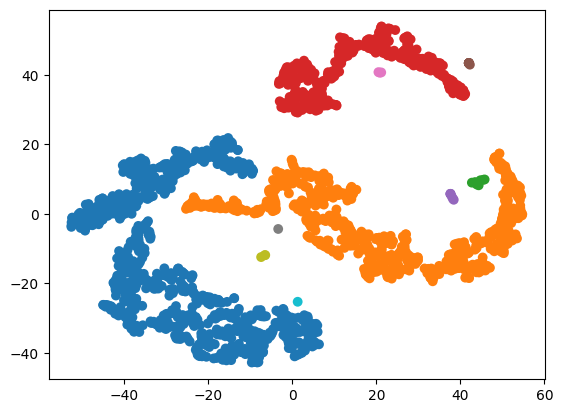

ShepardDiagram calculation took 0.18 seconds.


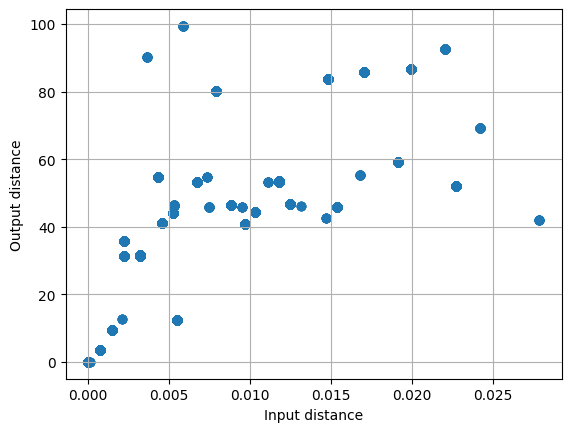

Continuity :  1.0001209260680481
Normalized Stress :  -0.07165487338670613


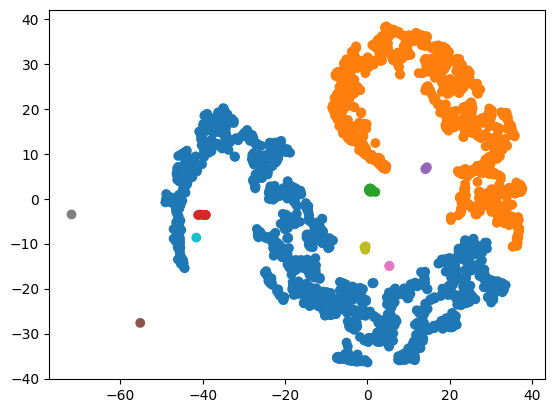

ShepardDiagram calculation took 0.10 seconds.


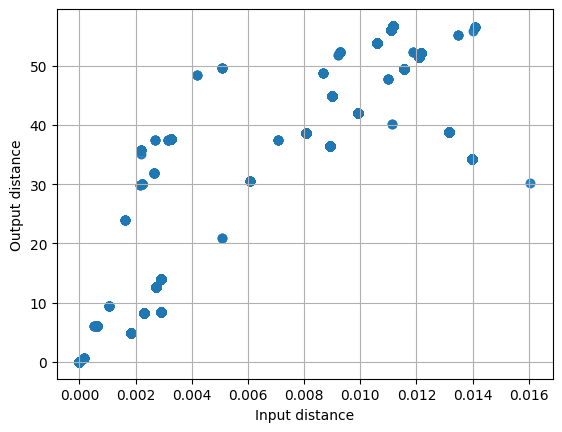

continuity :  1.0
normalized_stress :  -0.05540060072528962


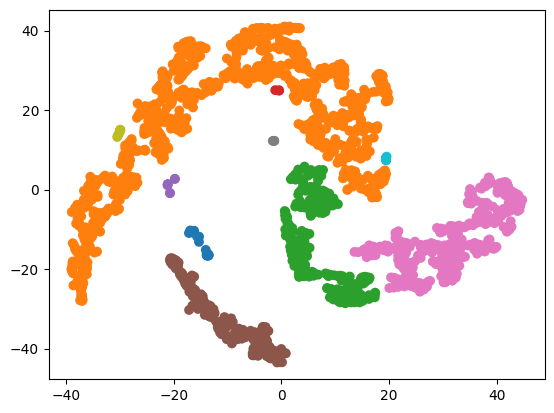

ShepardDiagram calculation took 0.11 seconds.


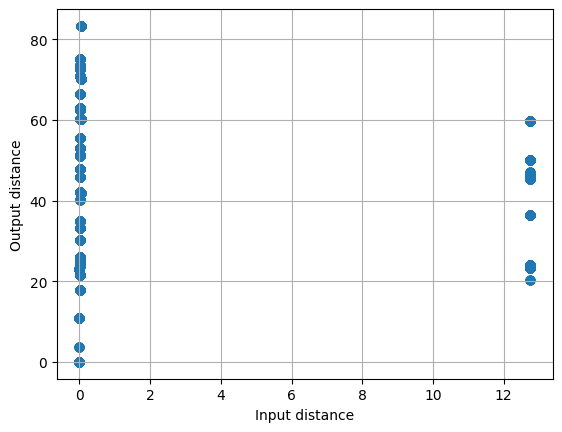

continuity :  1.0000002472925726
normalized_stress :  -1.933952087349757


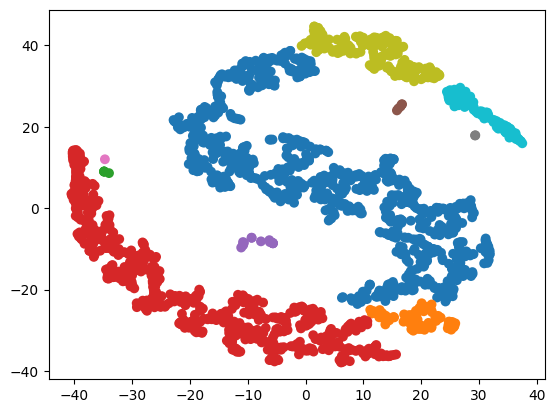

ShepardDiagram calculation took 0.16 seconds.


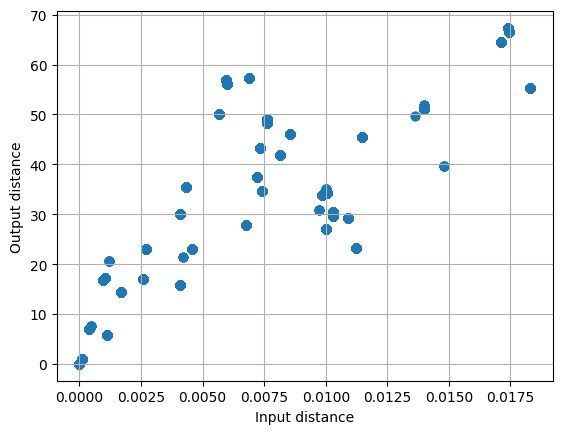

continuity :  1.0000197834058155
normalized_stress :  -0.09950453639982858


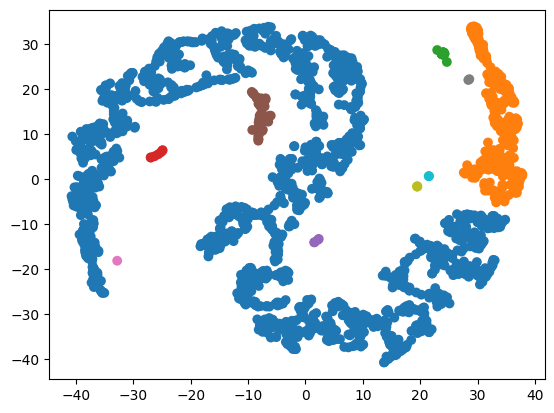

ShepardDiagram calculation took 0.12 seconds.


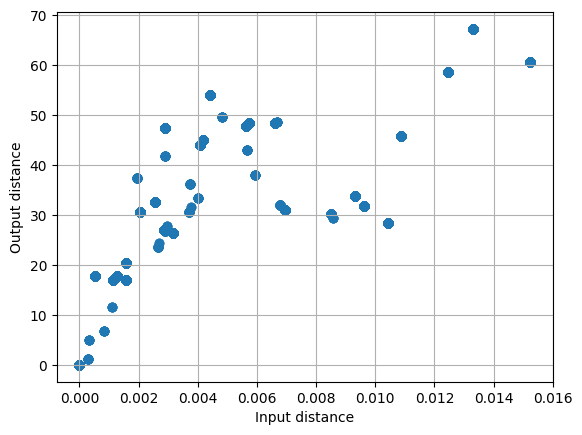

continuity :  1.0000002472925726
normalized_stress :  -0.08339965591197057


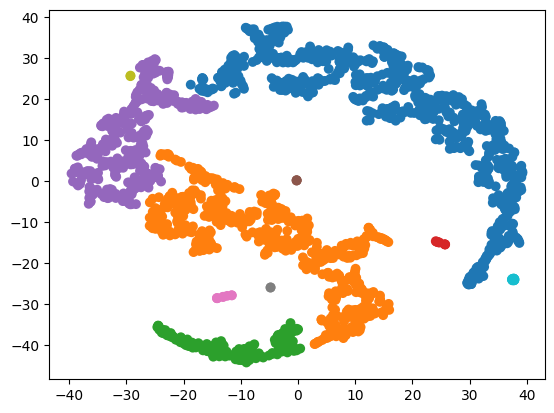

ShepardDiagram calculation took 0.11 seconds.


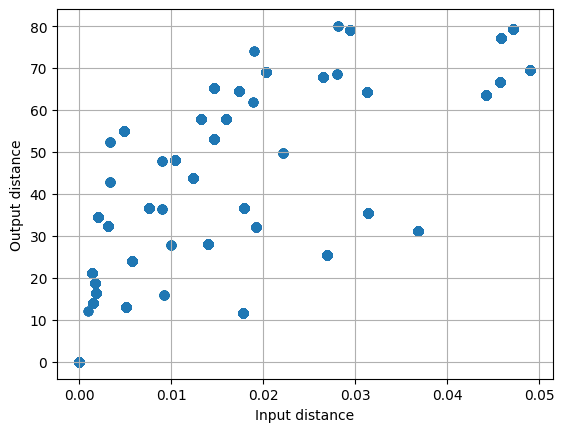

continuity :  1.0001288394303745
normalized_stress :  -0.41145081122002686


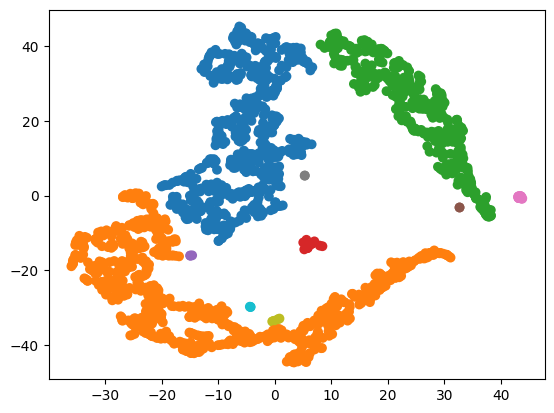

ShepardDiagram calculation took 0.11 seconds.


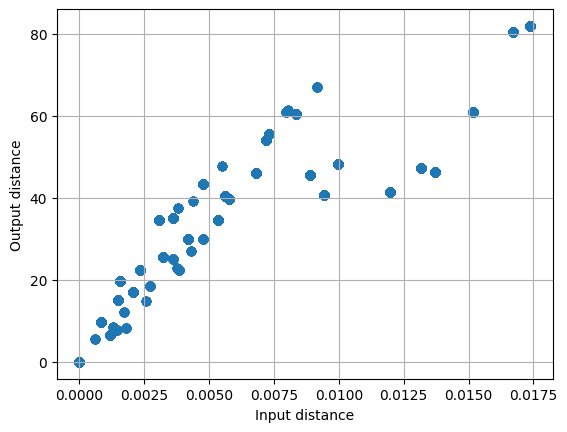

continuity :  1.0001293340155197
normalized_stress :  -0.006067598826747341


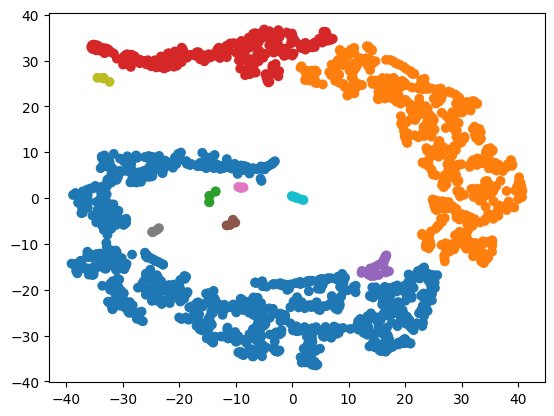

ShepardDiagram calculation took 0.11 seconds.


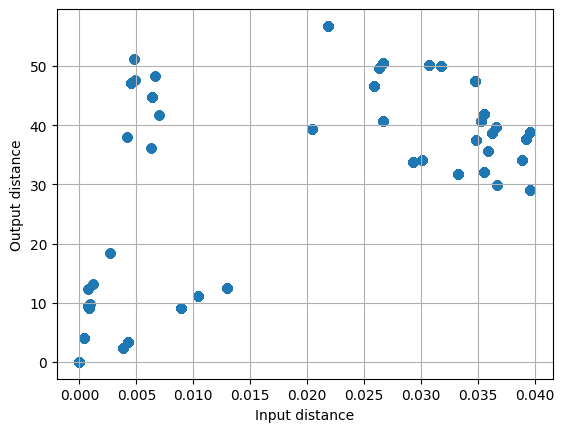

continuity :  1.0000185469429521
normalized_stress :  -0.0624087642184456


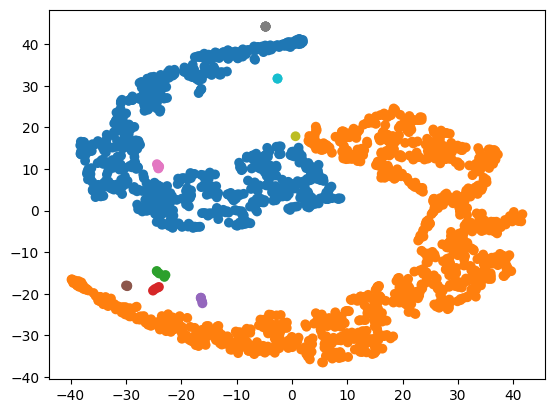

ShepardDiagram calculation took 0.16 seconds.


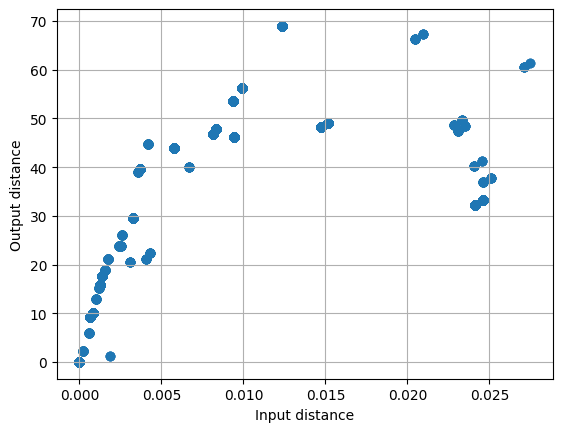

continuity :  1.0001177112646031
normalized_stress :  -0.0006899361704008345


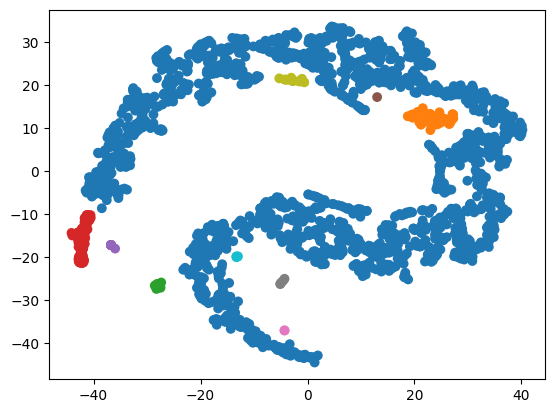

ShepardDiagram calculation took 0.11 seconds.


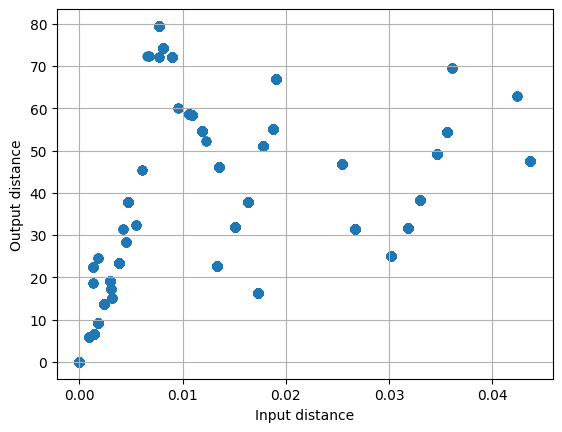

continuity :  1.0001174639720303
normalized_stress :  -0.12600784041622357


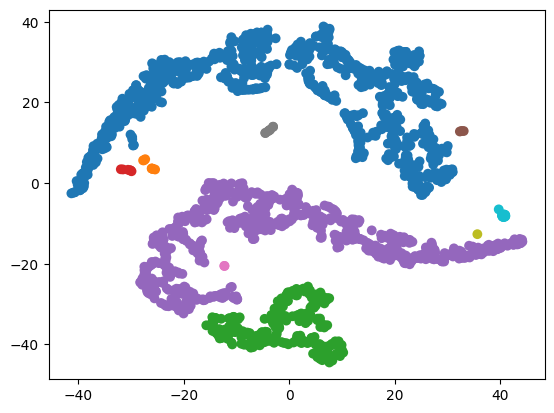

ShepardDiagram calculation took 0.12 seconds.


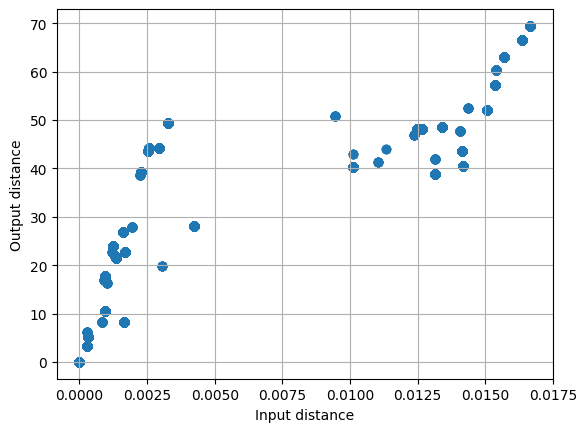

continuity :  1.0000007418777181
normalized_stress :  -0.1449944895236914


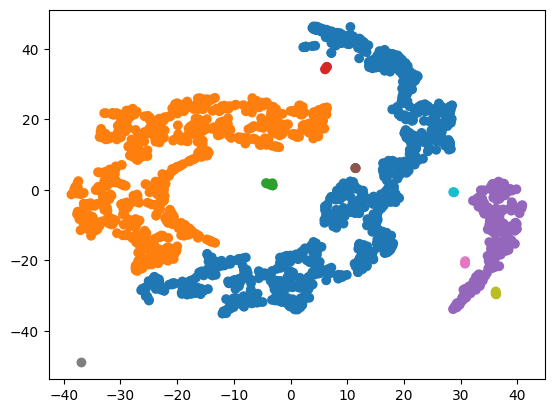

ShepardDiagram calculation took 0.11 seconds.


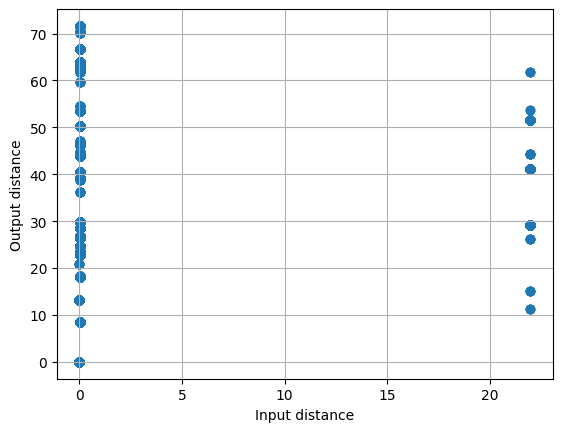

continuity :  1.000061575850601
normalized_stress :  -0.005243932382430583


In [22]:
jointTsne()